In [1]:
import numpy as np
from PIL import  Image
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
np.random.seed(25)

Load Cifar Images

In [2]:
!wget "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
!tar -xzvf "/content/cifar-10-python.tar.gz"

import pickle 

with open('/content/cifar-10-batches-py/data_batch_1', 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')

with open('/content/cifar-10-batches-py/batches.meta', 'rb') as fo:
        dict_labels = pickle.load(fo, encoding='bytes')
        
training_data_vec = dict[b'data']
training_labels = dict[b'labels']
training_labels = np.asarray(training_labels)

dict_labels

--2022-03-16 18:40:06--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  46.2MB/s    in 3.9s    

2022-03-16 18:40:10 (41.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

Plot images from each class

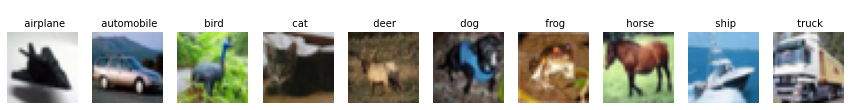

In [3]:
images = []  
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']  # Labels for the images

for i in range(10):

  idx = np.argwhere(training_labels == i)[0] 
  channels = []
  for i in range(3):
    channels.append(training_data_vec[idx].squeeze()[1024*i:1024*(i+1)].reshape(32,32))
  
  images.append(np.dstack(channels))

# Plotting images from each class

fig = plt.figure(figsize=(15, 10))
fig.tight_layout()

for i,label in enumerate(labels):

    ax = fig.add_subplot(5, 10, i+1)
    ax.axis('off')
    ax.set_title(f'\n  {label} ', fontsize=10)
    ax.imshow(images[i])
plt.show()

 ### Question 1


In [4]:
def convolution( image   ,kernel , nlf: str  ,padding: tuple = (0,0), stride: tuple = (1,1) ,  pad_bin: bool = 0  ):
  

  def Sigmoid(x):
    return 1/ (1+np.exp(-x))

  def TanH(x):
    return (2 / (1 + np.exp(-2*x)) - 1)

  def ReLU(x):
    return np.maximum(0,x)

  def PReLu(x):
    return np.where(x >= 0, x, 0.04 * x) 
  

  activation_fun = {
    'relu': ReLU,
    'sigmoid': Sigmoid,
    'Prelu': PReLu,
    'tanh': TanH
  }

  function = activation_fun[nlf]

  img_h,img_w,C  = image.shape
  kernel_h , kernel_w , C  = kernel.shape

  kernel = kernel / ((kernel_h**2 )*(kernel_w**2))
  
  stride_h,stride_w = stride
  pad_h,pad_w   =  padding
  

  padding_h = int( ( img_h - kernel_h + 2*(pad_h)) / stride_h ) + 1
  padding_w = int( (img_w - kernel_w + 2*(pad_w)) / stride_w  ) + 1

  output_img = np.zeros((padding_h , padding_w ))
  activation_map = np.zeros((padding_h , padding_w ))

  
  if pad_bin :
    im_pad  = padding_img(image,padding)
  else :
    im_pad = image

  count = 0
  for h in range(0,img_h,stride_h):                     
        for w in range(0,img_w,stride_w):                     
              count+=1
              v_start = h 
              v_end = v_start + kernel_h
              h_start = w
              horiz_end = h_start + kernel_w

              if ( h_start < (padding_w - kernel_w )) and ( v_start < (padding_h - kernel_h) ):
              # Slice the image for convolution    
                im_slice = im_pad[v_start:v_end , h_start:horiz_end , :]
              
                # elementwise multiplication
                conv_val = np.multiply(im_slice,kernel) # taking one kernel at a time
                # sum on convolved channels 
                output_img[h,w] = np.sum(conv_val) 
                activation_map[h,w] = function(output_img[h,w])
        

  return activation_map



In [5]:
def padding_img( image , pad_values: tuple ):


  pad_h,pad_w   =  pad_values 
  H,W,C = image.shape

  # output_img size image 
  H_pad =  H + 2*pad_h
  W_pad =  W + 2*pad_w

  # Padded image
  pad_img = np.zeros([H_pad,W_pad,C])

  for c in range(C) :
      pad_img[pad_h:-pad_h, :pad_w ,c   ] =  np.copy(image[:,:pad_w,c][:,::-1])  # First  columns reversed
      pad_img[pad_h:-pad_h, -pad_w :  ,c ] =   np.copy(image[:,-pad_w:,c][:,::-1])  # Last   columns reversed 

      # copy image to center
      pad_img[pad_h:-pad_h , pad_w:-pad_w,c] = np.copy(image[:,:,c])

      # Reverse first k and last k rows
      pad_img[:pad_h,:,c] = np.copy(pad_img[pad_h:2*pad_h,:,c][::-1]) #First two rows
      pad_img[-pad_h:,:,c] = np.copy(pad_img[-2*pad_h:-pad_h,:,c][::-1]) #LAst two rows

  return pad_img

In [6]:
# Testing the function 

inp_img = images[3]
rand_kernel = np.random.rand(3,3,3)


conv1 = convolution(inp_img,rand_kernel,nlf = 'Prelu',padding=(2,2),pad_bin=1) # With padding and Prelu activation



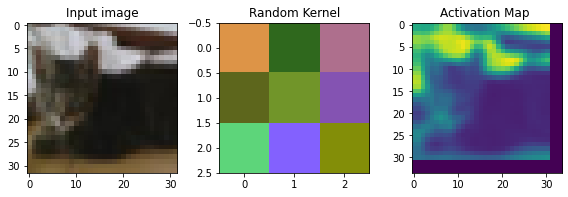

In [7]:


fig, axes = plt.subplots(nrows=1, ncols=3, 
                         figsize=(8,8))


axes[0].imshow(inp_img)
axes[0].set_title("Input image")
axes[1].imshow(rand_kernel)
axes[1].set_title("Random Kernel")
axes[2].imshow(conv1)
axes[2].set_title(f"Activation Map ")

plt.tight_layout()

Question 2

In [8]:
def Pooling_func(img_2d ,kernel_size = (2,2), func = 'Max',stride= (2,2)  ):


  ker_h,ker_w = kernel_size
  H,W = img_2d.shape
  stride_h,stride_w = stride

  def maxx(x):
    return np.amax(x)

  def avg(x):
    return np.sum(x) / (ker_h*ker_w)
  


  Pooling_functions ={'Max' : maxx ,'Avg':avg }
 

  H_out = int( ( H - ker_h )/stride_h ) + 1
  W_out = int( (W - ker_w )/stride_w ) + 1
  output = np.zeros([H_out,W_out])

  for h in range(0,H,stride_h):                     
      for w in range(0,W,stride_w):

        v_start = h 
        vert_end = v_start + ker_h
        h_start = w
        horiz_end = h_start + ker_w

        if ( h_start < (W_out - ker_w )) and ( v_start < (H_out - ker_h) ):

          # Slice the image for pooling    
          im_slice = img_2d[v_start:vert_end , h_start:horiz_end ]
          output[h,w] = Pooling_functions[func](im_slice[:,:])

  return output

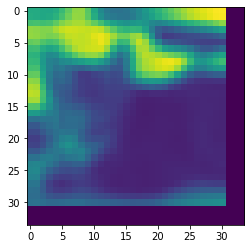

In [9]:
max_pool =  Pooling_func(img_2d= conv1 ,kernel_size = (2,2), func = 'Max',stride= (2,2))
plt.imshow(conv1)

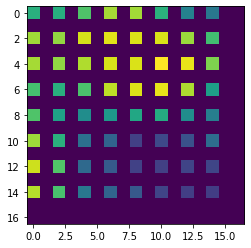

In [10]:
plt.imshow(max_pool)

Question 3

In [11]:
def convolutional_layer( img   ,kernel , non_lin_fun  ,padding = (0,0), stride = (1,1) ,  pad_bin = 0 ):

  H,W,C  = img.shape
  k_h , k_w , C ,out_channel  = kernel.shape
  
  pad_h,pad_w   =  padding
  stride_h,stride_w = stride

  H_out = int( ( H - k_h + 2*(pad_h))/stride_h ) + 1
  W_out = int( (W - k_w + 2*(pad_w))/stride_w  ) + 1
  activation_map = np.zeros([H_out,W_out,out_channel])

  for c in range(out_channel) :
    activation_map[:,:,c] = convolution(img ,kernel[:,:,:,c],nlf = non_lin_fun ,padding = padding , stride = stride , pad_bin = pad_bin)

  return activation_map

The convolution layer output is (34, 34, 3)


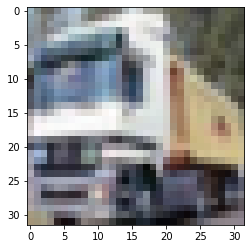

In [13]:
input1 = images[9]
filter = np.random.rand(3,3,3,3) 

convo_out =convolutional_layer(input1 , filter ,non_lin_fun = 'relu', padding=(2,2),  pad_bin=1 )  
print(f"The convolution layer output is {convo_out.shape}")

plt.imshow(input1)



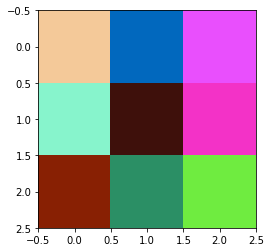

In [14]:
plt.imshow(filter[:,:,:,0])  # One of the three kernels

Text(0.5, 1.0, 'First channel')

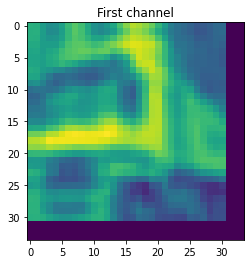

In [15]:

plt.imshow(convo_out[:,:,0])
plt.title('First channel')


Text(0.5, 1.0, 'Second channel')

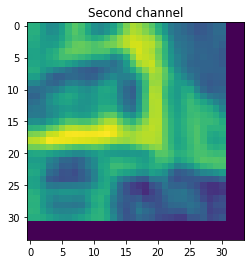

In [16]:
plt.imshow(convo_out[:,:,1])
plt.title('Second channel')

Text(0.5, 1.0, 'Third channel')

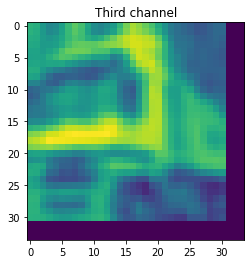

In [17]:
plt.imshow(convo_out[:,:,2])
plt.title('Third channel')

In [18]:
def Pooling_fun_layer(img ,kernel_size = (2,2), func = 'Max',stride = (2,2) ):

  ker_h,ker_w = kernel_size
  H,W,C = img.shape
  stride_h,stride_w = stride

  H_out = int( ( H - ker_h )/stride_h ) + 1
  W_out = int( (W - ker_w )/stride_w ) + 1
  output = np.zeros([H_out,W_out,C])

  for c in range(C):
    output[:,:,c] = Pooling_func(img_2d = img[:,:,c] ,kernel_size = kernel_size , func = func,stride = stride  )

  return output

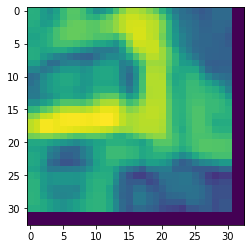

In [19]:
max_pooled_output =  Pooling_fun_layer(convo_out,kernel_size = (2,2),stride = (1,1),func = 'Max') 

plt.imshow(max_pooled_output[:,:,1])


In [20]:
def flatten_img(img) :

  img = img.reshape(1,-1).squeeze()

  inp_size = img.size

  W = np.random.uniform(-1,1,size = (inp_size , (512) ))
  bias = np.random.rand(1, 512 )

  output = np.dot(img,W) + bias

  return output

In [21]:
def Multi_layer_per(inp_vec ,n_hidden_layers, layer_size, non_lin_fun, output_layer_size ):

  def Sigmoid(x):
    return 1/ (1+np.exp(-x))

  def TanH(x):
    return (2 / (1 + np.exp(-2*x)) - 1)

  def ReLU(x):
    return np.maximum(0,x)

  def PReLu(x):
    return np.where(x >= 0, x, 0.04 * x) 
  
  def Softmax(x):
    return np.exp(x) / np.sum(np.exp(x))
  

  activation_fun = {
    'relu': ReLU,
    'sigmoid': Sigmoid,
    'softmax' : Softmax,
    'Prelu': PReLu,
    'tanh': TanH
  }

  activation_func = activation_fun[non_lin_fun]

  in_size = inp_vec.size
  hidden_units_list = np.insert(layer_size,0,in_size)
  hidden_units_list = np.append(hidden_units_list,output_layer_size)

  Weights_list = []
  Biases_list  = []
  i = 0
  X = inp_vec
  loop_length = len(hidden_units_list) -1

  for h_u in range(0,loop_length):

     Weights_list.append( np.random.uniform(-1,1,size = (hidden_units_list[h_u] , hidden_units_list[h_u + 1])) )
     Biases_list.append (  np.zeros((1, hidden_units_list[h_u + 1])) )
     output = np.dot(X,Weights_list[i]) + Biases_list[i]

     activated_output = activation_func(output)
     X =  activated_output
     i += 1

  softmax_output = Softmax(activated_output)

  return activated_output , softmax_output

In [22]:


def feed_forward( img):
  
  X = convolutional_layer( img = img  ,kernel = np.random.rand(3,3,3,16) , non_lin_fun = 'sigmoid' ) 
  
  
  X = Pooling_fun_layer(X ,kernel_size = (2,2), func = 'Max',stride = (2,2) )
  
  
  X = convolutional_layer( img = X  ,kernel = np.random.rand(3,3,16,8) , non_lin_fun = 'sigmoid' ) 
  
  
  X = Pooling_fun_layer(X ,kernel_size = (2,2), func = 'Max',stride = (2,2) )
  

  X = flatten_img(X)
 

  X ,softmax = Multi_layer_per(X ,n_hidden_layers =1 ,layer_size = [100] , non_lin_fun = 'sigmoid', output_layer_size = 10)
 

  return softmax 

In [23]:
# Test the function 
# a,b,c = feed_forward(images[1])

Question 8

In [24]:
# Display 10 output vectors for corresponding classes
for i in range(10):
  print(f"Image {i} :")
  softmax = feed_forward(images[i])
  print(f"softmax ouptut is {softmax}")
 

Image 0 :
softmax ouptut is [[0.12608364 0.05660787 0.04685782 0.12711765 0.04763119 0.12459336
  0.1162433  0.12072028 0.1265053  0.10763958]]
Image 1 :
softmax ouptut is [[0.06175463 0.13392385 0.05686797 0.12841677 0.05678761 0.05761924
  0.05672079 0.15377235 0.14269813 0.15143866]]
Image 2 :
softmax ouptut is [[0.05732357 0.05958051 0.09414282 0.13091557 0.09762317 0.1442643
  0.14370965 0.13742443 0.05828238 0.07673359]]
Image 3 :
softmax ouptut is [[0.06159038 0.1466464  0.06367253 0.06102634 0.16032537 0.07037634
  0.05944839 0.05945074 0.15876726 0.15869627]]
Image 4 :
softmax ouptut is [[0.14496679 0.17123071 0.08603667 0.07299463 0.06406084 0.07155587
  0.10679403 0.06354959 0.14832691 0.07048397]]
Image 5 :
softmax ouptut is [[0.055987   0.08634832 0.08098495 0.0829562  0.14205231 0.06655142
  0.1458555  0.13820996 0.05770331 0.14335104]]
Image 6 :
softmax ouptut is [[0.06579255 0.17136211 0.06319172 0.06377659 0.16999971 0.09224936
  0.07279923 0.06556195 0.06633974 0.1689

There is no trend visible.

In [25]:
# Create a list of 30 images where 3 images per class is considered

images_30 = [] 
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'] 
color_list = ["blue","orange","green","red","purple","brown","pink","gray","olive","cyan" ]

for i in range(10):

  index = np.argwhere(training_labels == i)[:3].squeeze() # Find index of single image from each class  
  for j in index:
    
    channel = []
    for i in range(3):
      channel.append(training_data_vec[j].squeeze()[1024*i:1024*(i+1)].reshape(32,32))
    
    images_30.append(np.dstack(channel))

In [26]:


def feed_forward_flat( img):
  
  X = convolutional_layer( img = img  ,kernel = np.random.rand(3,3,3,16) , non_lin_fun = 'sigmoid' ) 
  
  
  X = Pooling_fun_layer(X ,kernel_size = (2,2), func = 'Max',stride = (2,2) )
  
  
  X = convolutional_layer( img = X  ,kernel = np.random.rand(3,3,16,8) , non_lin_fun = 'sigmoid' ) 
  
  
  X = Pooling_fun_layer(X ,kernel_size = (2,2), func = 'Max',stride = (2,2) )
  

  X = flatten_img(X)
  

  return X 

In [27]:
Bottle_neck_layer_outputs = np.zeros((30,512))

for i in range(30):
  
  flattened_output = feed_forward_flat(images_30[i])
  Bottle_neck_layer_outputs[i,:] = np.copy(flattened_output)

### TSNE PLot

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'TSNE plot of Bottleneck layer')

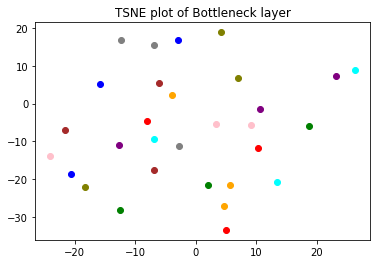

In [28]:
from sklearn.manifold import TSNE

X_embed = TSNE(perplexity = 5, learning_rate="auto" ).fit_transform(Bottle_neck_layer_outputs)

for i in range(30):

  plt.scatter(X_embed[i,0],X_embed[i,1],color=color_list[i//3])
  

plt.title("TSNE plot of Bottleneck layer")

No, a randomly initialized network doesn't show any discriminability.